# Machine Learning - Assignment 1 (PS3)

The assignment is submitted by:
<span style="color:blue"> <b> Vidushi Bhatia, 2024AC05012</b></span>.

#### Table of Contents

1. Problem Overview
2. Import Libraries
3. Data Visualization & Exploration
4. Data Preprocessing
5. Model Building <br>
       5.1 Split train and test <br>
       5.2 Choose classifier model <br>
       5.3 Hyperparameter Tuning <br>
7. Performance Evaluation
8. Conclusion


### 1. Problem Overview <a class="anchor" id="overview"></a>

The given problem is about assessing the **potability (drinkability)** of `3276` water samples using various features. The dataset contains several independent variables (such as pH, hardness, solids, etc.) that describe the quality of water, and a target label indicating whether the water is **potable (1) or not potable (0)**.

As the target variable is **binary**, the goal is to build and evaluate **classification models** that can accurately predict whether a given water sample is safe for human consumption based on the given features. 

### 2. Import Libraries & Dataset


In [1]:
# for database manipulations
import pandas as pd

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for data processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

# for modeling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# for evaluation
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix

# removing warnings from outputs
import warnings
warnings.filterwarnings("ignore")

In [2]:
# read given input data
print("\n********************** Reading Input Data **********************\n")
input_data = pd.read_csv('water_potability.csv')
print(f"Shape of the given dataset is: {input_data.shape}\n")
input_data.describe()


********************** Reading Input Data **********************

Shape of the given dataset is: (3276, 10)



,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [3]:
# convert all col names to lower for consistency

input_data.columns = input_data.columns.str.lower()

#### 📊 Initial Observations:
- `ph, sulfate, trihalomethanes` columns seems to have missing values as the `count` is not the same as `shape`.
- `solids, trihalomethanes` 75% is significantly less than the `max`, it might have right skewed data and outliers.
- `turbidity` has very little spread compared to other variables as `min` and `max` are close.


<br>
<hr>
<br>

### 2. Data Visualization and Exploration

In this section, we understand:
- target class distribution
- feature distribution
- pairplot analysis
- correlation analysis

In [4]:
# sanity check: manual checks for some rows.
print("\n********************** Top 10 Rows **********************\n")

input_data.head(10)


********************** Top 10 Rows **********************



,ph,hardness,solids,chloramines,sulfate,conductivity,organic_carbon,trihalomethanes,turbidity,potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0
8,NaN,118.988579,14285.583854,7.804174,268.646941,389.375566,12.706049,53.928846,3.595017,0
9,11.180284,227.231469,25484.508491,9.077200,404.041635,563.885481,17.927806,71.976601,4.370562,0



********************** Target Class Distribution **********************

potability
0    0.60989
1    0.39011
Name: proportion, dtype: float64 



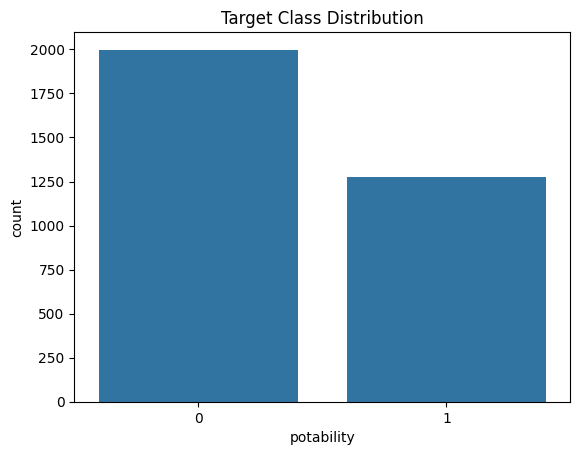

In [5]:
# class imbalance
print("\n********************** Target Class Distribution **********************\n")

print(f"{input_data.potability.value_counts(normalize=True)} \n")


sns.countplot(x='potability', data=input_data)
plt.title('Target Class Distribution')
plt.show()


********************** Feature Distribution **********************



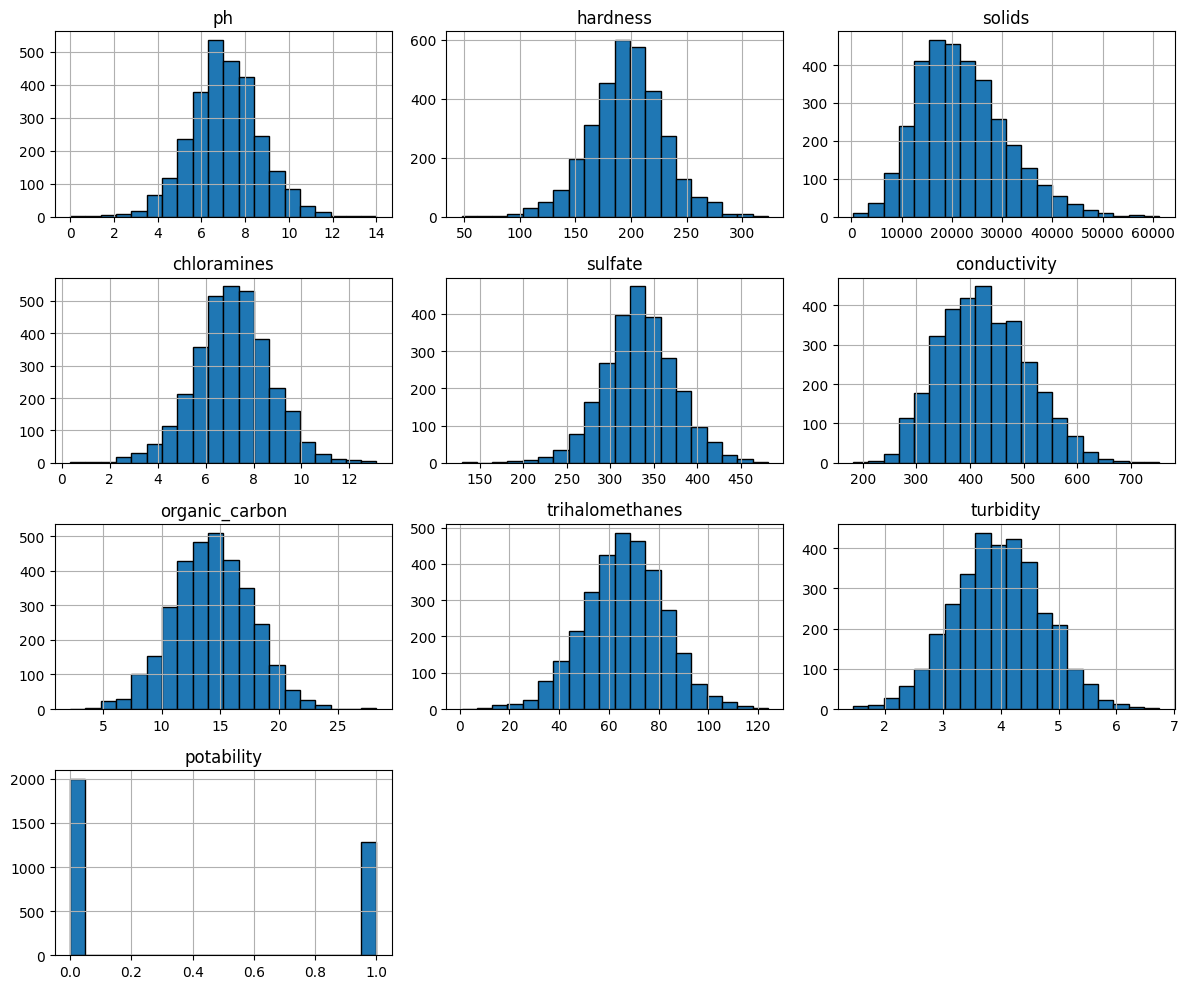

In [7]:
# check the spread  of each independent variable
print("\n********************** Feature Distribution **********************\n")

input_data.hist(figsize=(12,10), bins=20, edgecolor='black')
plt.tight_layout()
plt.show()


********************** Independent Variables vs Target **********************



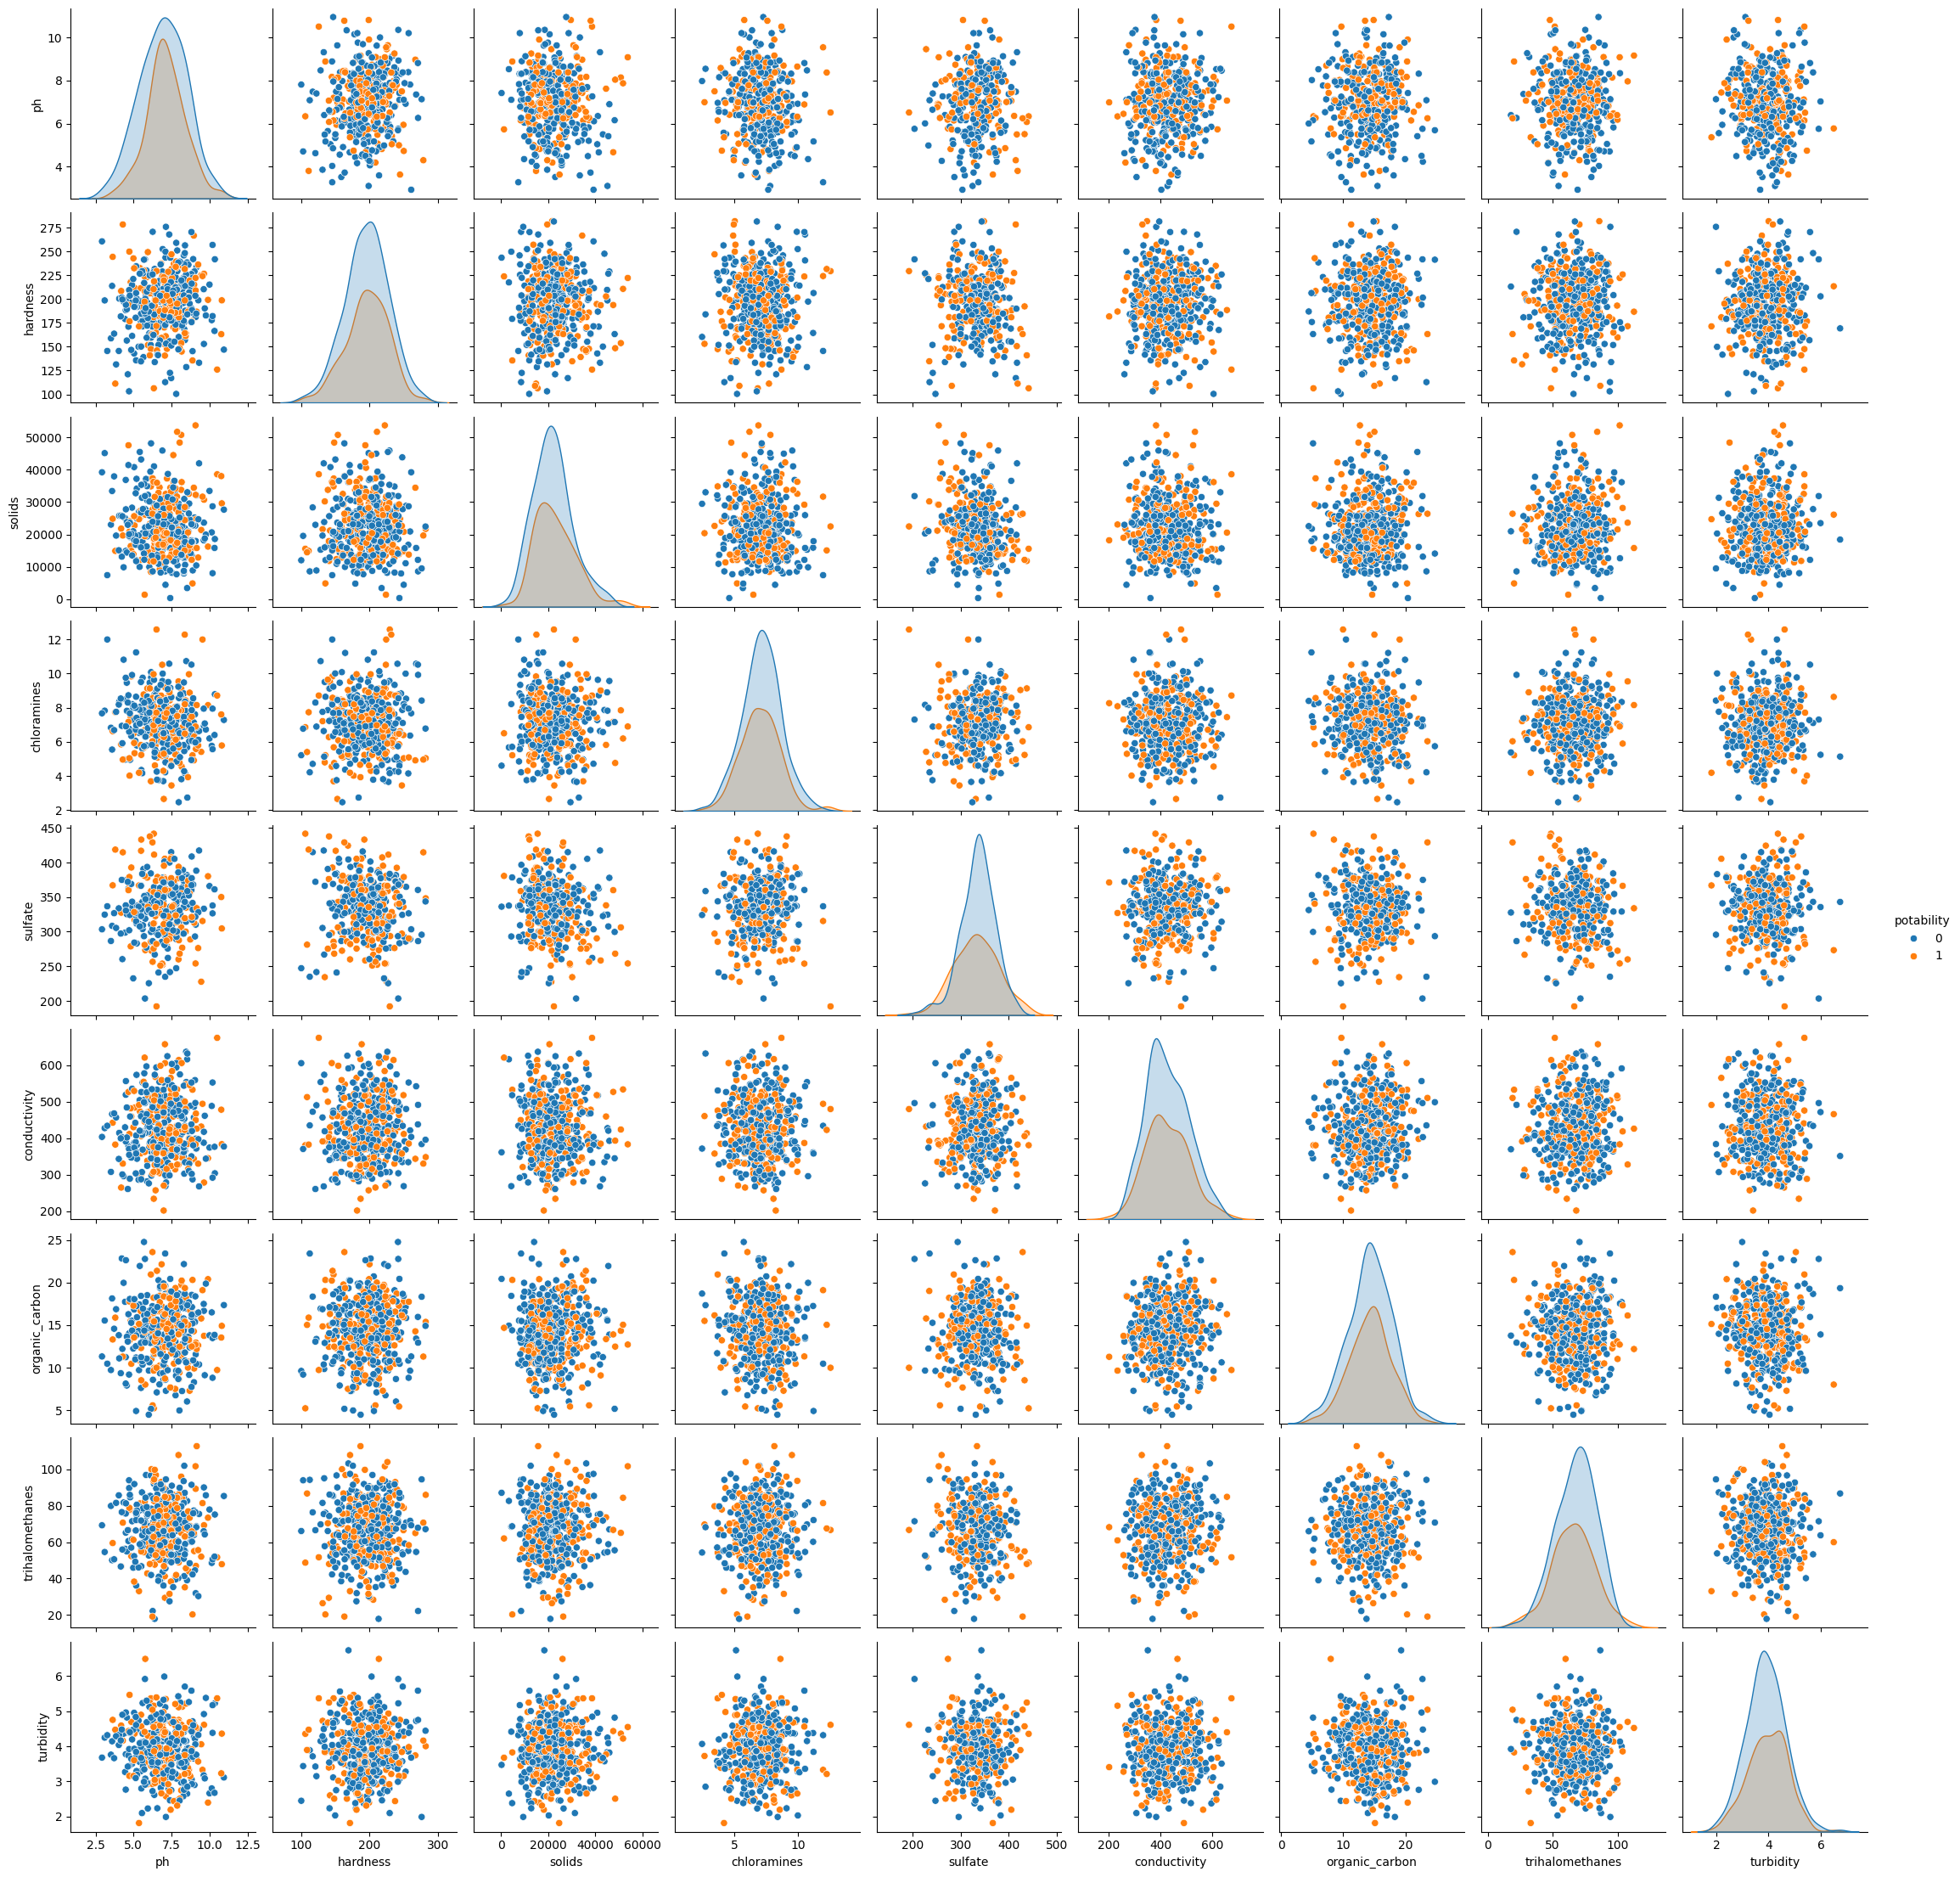

In [10]:
# How do each feature relate to the target variable

print("\n********************** Independent Variables vs Target **********************\n")

sns.pairplot(input_data.sample(500), hue='potability', vars=input_data.columns[:-1])


********************** Correlation Analysis: **********************



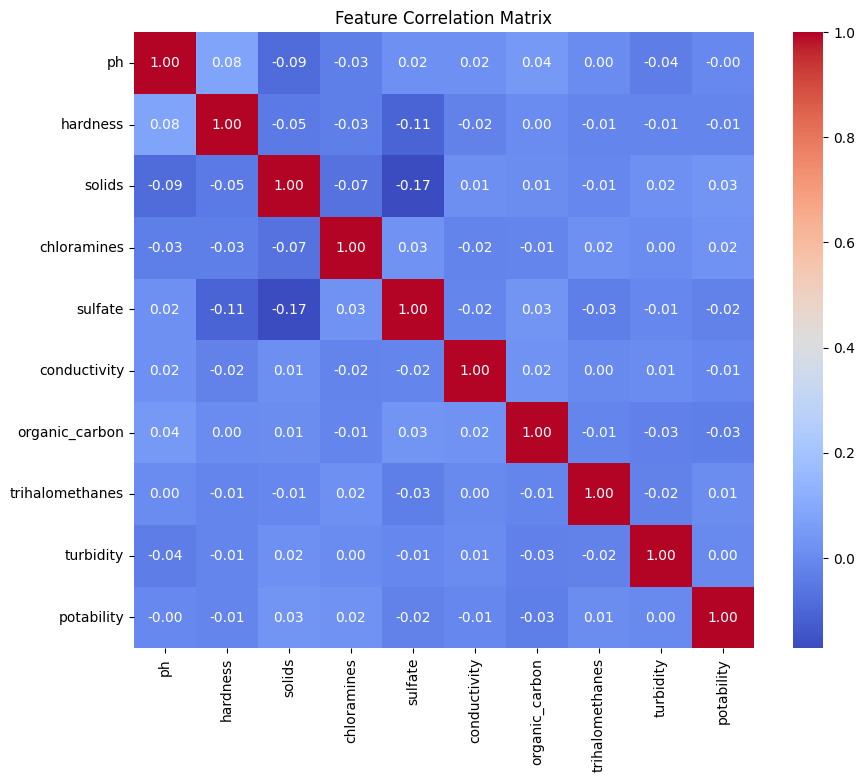

In [11]:
# Are features correlated?

print("\n********************** Correlation Analysis: **********************\n")

corr = input_data.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

#### 📊 Observations:
- Histograms reveal feature distribution (normal, skewed); pairplot shows potential class separation.
- High correlations between features (multicollinearity) can lead to redundancy. In such cases, we might drop or combine highly correlated variables to reduce dimensionality without losing information. This will guide feature selection or dimensionality reduction steps later.


<br>
<hr>
<br>

### 3. Data Pre-processing

The following pre-processing steps are applied in this section:
- Missing value detection and imputation  
- Outlier detection and handling if needed  
- Feature scaling (standardization/normalization)
- more transformations???


In [12]:
# - Missing value detection and imputation  
print("\n********************** Missing Values in Data: **********************\n")
print(input_data.isnull().sum())


# Impute with median for numeric features
print("\n********************** Post Imputation: **********************\n")

num_cols = input_data.columns[:-1]
imputer = SimpleImputer(strategy='median')
input_data[num_cols] = imputer.fit_transform(input_data[num_cols])
print(input_data.isnull().sum())


********************** Missing Values in Data: **********************

ph                 491
hardness             0
solids               0
chloramines          0
sulfate            781
conductivity         0
organic_carbon       0
trihalomethanes    162
turbidity            0
potability           0
dtype: int64

********************** Post Imputation: **********************

ph                 0
hardness           0
solids             0
chloramines        0
sulfate            0
conductivity       0
organic_carbon     0
trihalomethanes    0
turbidity          0
potability         0
dtype: int64


In [15]:
# - Outlier detection and handling if needed  

print("\n********************** Outlier Detection: **********************\n")

# run a loop for all features
Q1 = input_data['ph'].quantile(0.25)
Q3 = input_data['ph'].quantile(0.75)
IQR = Q3 - Q1

min_threshold = Q1 - 1.5*IQR
max_threshold = Q3 + 1.5*IQR
print("Outliers found based on mean and sd",
print("Outliers found based on IQR", input_data[(input_data['ph'] >= min_threshold) & (input_data['ph'] <= max_threshold)])
input_data = input_data[(input_data['ph'] >= min_threshold) & (input_data['ph'] <= max_threshold)]



********************** Outlier Detection: **********************

Outliers found based on IQR             ph    hardness        solids  chloramines     sulfate  \
0     7.036752  204.890455  20791.318981     7.300212  368.516441   
2     8.099124  224.236259  19909.541732     9.275884  333.073546   
3     8.316766  214.373394  22018.417441     8.059332  356.886136   
4     9.092223  181.101509  17978.986339     6.546600  310.135738   
5     5.584087  188.313324  28748.687739     7.544869  326.678363   
...        ...         ...           ...          ...         ...   
3271  4.668102  193.681735  47580.991603     7.166639  359.948574   
3272  7.808856  193.553212  17329.802160     8.061362  333.073546   
3273  9.419510  175.762646  33155.578218     7.350233  333.073546   
3274  5.126763  230.603758  11983.869376     6.303357  333.073546   
3275  7.874671  195.102299  17404.177061     7.509306  333.073546   

      conductivity  organic_carbon  trihalomethanes  turbidity  potability  

In [16]:
# - Feature scaling (standardization/normalization) with justification 

scaler = StandardScaler()
input_data.loc[:, num_cols] = scaler.fit_transform(input_data[num_cols])

#### 📊 Observations:
- Histograms reveal feature distribution (normal, skewed); pairplot shows potential class separation.
- High correlations between features (multicollinearity) can lead to redundancy. In such cases, we might drop or combine highly correlated variables to reduce dimensionality without losing information. This will guide feature selection or dimensionality reduction steps later.


<br>
<hr>
<br>

### 4. Model Building [11M]

In this section, ...


#### 4.1 Split Train Test

**Split the dataset into training and test sets. Answer without justification will not be awarded marks.** [1]
- Train = 80 % Test = 20% 
- Also, try to split the dataset with different ratios of your choice.

In [17]:
# split target and independent variables
print("\n********************** Outlier Detection: **********************\n")

X = input_data.drop('potability', axis=1)
y = input_data['potability']


********************** Outlier Detection: **********************



In [18]:
# 80-20 split
print("\n********************** Stratified Sampling: **********************\n")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

print("train distribution: ", y_train.value_counts(normalize = True))
print("\ntest distribution: ", y_test.value_counts(normalize = True))



********************** Stratified Sampling: **********************

train distribution:  potability
0    0.604308
1    0.395692
Name: proportion, dtype: float64

test distribution:  potability
0    0.604466
1    0.395534
Name: proportion, dtype: float64


##### 📊 Observations:
- Histograms reveal feature distribution (normal, skewed); pairplot shows potential class separation.
- High correlations between features (multicollinearity) can lead to redundancy. In such cases, we might drop or combine highly correlated variables to reduce dimensionality without losing information. This will guide feature selection or dimensionality reduction steps later.

Stratified split ensures both train/test sets maintain the same class distribution ratio, preventing bias.

You can optionally test other ratios like 70/30 or 90/10 to compare stability of results.

<br>
<hr>
<br>


#### 4.2 Predictive Models

**Implement predictive models/classifiers using the following classification approaches**:    [8]
- Logistic Regression
- Decision tree
- K-Nearest Neighbour
- Ensemble Methods (any one of your choice)



In [19]:
# Define models and their parameter grids
models = {
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {'C': [0.01, 0.1, 1, 10]}
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(),
        'params': {'max_depth': [None, 5, 10, 20]}
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {'n_neighbors': [3,5,7,9]}
    },
    'RandomForest': {
        'model': RandomForestClassifier(),
        'params': {'n_estimators': [50,100,200], 'max_depth': [None,10,20]}
    }
}

best_models = {}
for name, mp in models.items():
    grid = GridSearchCV(mp['model'], mp['params'], cv=5,
                        scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid
    print(f"{name}: Best params: {grid.best_params_}, CV AUC: {grid.best_score_:.3f}")


LogisticRegression: Best params: {'C': 10}, CV AUC: 0.520
DecisionTree: Best params: {'max_depth': 10}, CV AUC: 0.568
KNN: Best params: {'n_neighbors': 7}, CV AUC: 0.627
RandomForest: Best params: {'max_depth': 10, 'n_estimators': 200}, CV AUC: 0.662


#### 📊 Observations:
Justification:

Logistic Regression: C controls regularization strength—tuning prevents overfitting/underfitting.

Decision Tree: max_depth limits complexity—balances bias/variance.

KNN: n_neighbors affects smoothing.

Random Forest: Ensemble reduces overfitting; tuning n_estimators and max_depth controls strength and overfitting.
<br>
<hr>
<br>


#### 4.3 Hyperparameter Tuning

**Tune hyperparameters** (e.g., number of trees, maximum depth) using cross-validation. For each of the above models. Justify your answer. [2]


#### 📊 Observations:
- Histograms reveal feature distribution (normal, skewed); pairplot shows potential class separation.
- High correlations between features (multicollinearity) can lead to redundancy. In such cases, we might drop or combine highly correlated variables to reduce dimensionality without losing information. This will guide feature selection or dimensionality reduction steps later.

Stratified split ensures both train/test sets maintain the same class distribution ratio, preventing bias.

You can optionally test other ratios like 70/30 or 90/10 to compare stability of results.

<br>
<hr>
<br>


#### 5. Performance Evaluation [6M]

- Compare the performances of each model/classifier considering the given dataset using different evaluation measures such as Precision, Recall, F1-Score, AUC-ROC. Show the comparison chart in Python notebook [4]

In [20]:
results = []
for name, grid in best_models.items():
    y_pred = grid.predict(X_test)
    y_prob = grid.predict_proba(X_test)[:,1]
    report = classification_report(y_test, y_pred, output_dict=True)
    auc = roc_auc_score(y_test, y_prob)
    results.append({
        'Model': name,
        'Precision': report['1']['precision'],
        'Recall': report['1']['recall'],
        'F1-Score': report['1']['f1-score'],
        'AUC': auc
    })

results_df = pd.DataFrame(results)
results_df


,Model,Precision,Recall,F1-Score,AUC
0,LogisticRegression,1.000000,0.004032,0.008032,0.467125
1,DecisionTree,0.535211,0.306452,0.389744,0.597141
2,KNN,0.500000,0.358871,0.417840,0.601429
3,RandomForest,0.742857,0.209677,0.327044,0.668738


- Identify the model, which you think is the best amongst all the models that have been trained. Also, explain why you think this is the best model. Answer this question in the notebook itself.  [2]


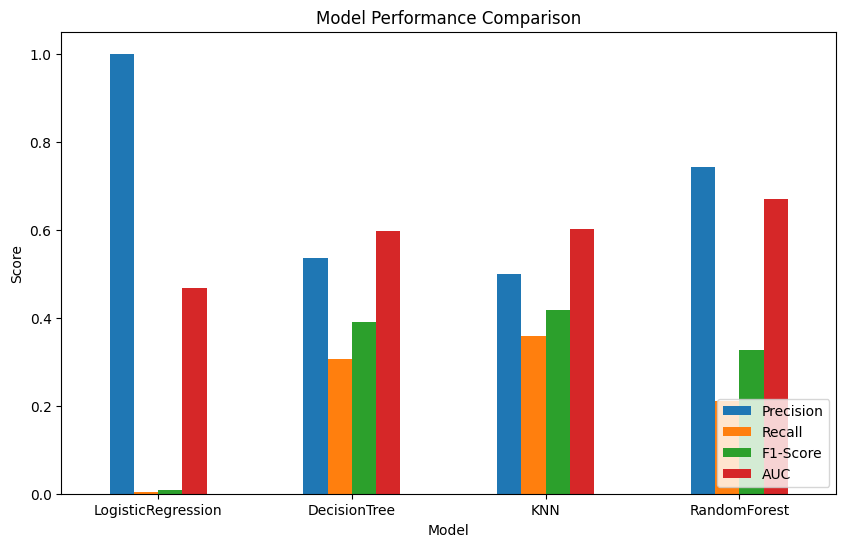

In [21]:
# Plotting comparison
results_df.set_index('Model')[['Precision','Recall','F1-Score','AUC']].plot(
    kind='bar', figsize=(10,6))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()


**Best Model**: [Insert chosen model name]


Justification:

Compare metrics: precision/recall/F1/AUC.

Example: If RandomForest shows highest AUC and balanced precision-recall, it's preferred for its ensemble robustness and generalization performance.

